In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [24]:
df = pd.read_csv('credit_card_fraud_dataset/creditcard.csv')
df.shape

(284807, 31)

# 데이터 가공 없음

In [9]:
X_data = df.iloc[:,:-1]
y_target = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X_data,y_target,
                                                       test_size=0.2,
                                                       random_state=11,
                                                       stratify=y_target)

lr_clf = LogisticRegression()
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)

lr_clf.fit(X_train, y_train)
lgbm_clf.fit(X_train, y_train)

lr_pred = lr_clf.predict(X_test)
lgbm_pred = lgbm_clf.predict(X_test)

def get_eval_score(y_test, pred=None, pred_proba=None):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred_proba)
    print(f'정확도 : {accuracy : .4f} \n정밀도 : {precision : .4f} \n재현율 : {recall : .4f} \nF1 : {f1 : .4f} \nAUC : {auc : .4f}')
    
print('LogisticRegression 평가지표')
get_eval_score(y_test, pred=lr_pred, pred_proba = lr_clf.predict_proba(X_test)[:,1])
print('LGBM 평가지표')
get_eval_score(y_test, pred=lgbm_pred, pred_proba = lgbm_clf.predict_proba(X_test)[:,1])

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression 평가지표
정확도 :  0.9989 
정밀도 :  0.6731 
재현율 :  0.7143 
F1 :  0.6931 
AUC :  0.9255
LGBM 평가지표
정확도 :  0.9997 
정밀도 :  0.9765 
재현율 :  0.8469 
F1 :  0.9071 
AUC :  0.9798


# log 변환

In [10]:
def fit_eval(model, xtrain=None, xtest=None, ytrain=None, ytest=None):
    model.fit(xtrain, ytrain)
    pred = model.predict(xtest)
    pred_proba = model.predict_proba(xtest)[:,1]
    get_eval_score(ytest,pred, pred_proba)

In [12]:
def preprocess_df(df=None):
    df_copy = df.copy()
    amount = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [46]:
def split_data(df=None):
    df_copy = preprocess_df(df)
    X_data = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:, -1]
    
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_target,
                                                       test_size=0.2,
                                                       random_state=11,
                                                       stratify=y_target)
    return X_train, X_test, y_train, y_test

In [14]:
X_train, X_test, y_train, y_test = split_data(df)
print('LogisticRegression 평가 지표')
fit_eval(lr_clf, xtrain=X_train, xtest=X_test, ytrain=y_train, ytest=y_test)
print('LGBM 평가 지표')
fit_eval(lgbm_clf, xtrain=X_train, xtest=X_test, ytrain=y_train, ytest=y_test)

LogisticRegression 평가 지표
정확도 :  0.9992 
정밀도 :  0.8611 
재현율 :  0.6327 
F1 :  0.7294 
AUC :  0.9710
LGBM 평가 지표
정확도 :  0.9997 
정밀도 :  0.9651 
재현율 :  0.8469 
F1 :  0.9022 
AUC :  0.9804


# log변환, 이상치 제거

### seaborn cmap의 color palette 선정 기준
- sequential palette (ex : RdPu)
 - 밝은 색~어두운색까지 연속적으로 나타남. 
 - Ranking 같은 데이터에 사용하면 높은값이 강조되며 사용하기 좋다

- diverging palette (ex : RdBu)
 - 양쪽으로 강조가 됨
 - 낮은값, 높은 값 모두 봐야하는 데이터 셋에 사용하기 좋다


<AxesSubplot:>

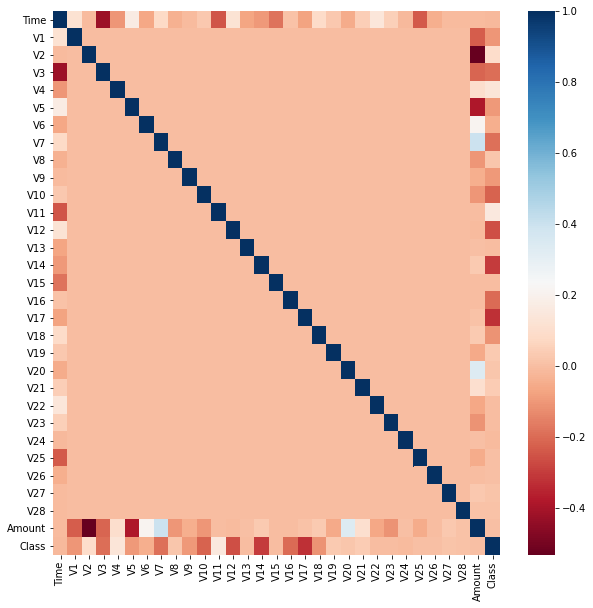

In [17]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), cmap='RdBu')

In [62]:
def get_outlier(df, column=None):
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * 1.5
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    outlier = fraud[(fraud < lowest_val) | (fraud>highest_val)].index
    
    return outlier

In [63]:
def preprocess_df(df=None):
    df_copy = df.copy()
    amount = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    
    outlier_12 = get_outlier(df_copy, column='V12')
    df_copy.drop(outlier_12, axis=0, inplace=True)

    return df_copy

In [64]:
lr_clf = LogisticRegression()
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)

X_train, X_test, y_train, y_test = split_data(df)
print('LogisticRegression 평가 지표')
fit_eval(lr_clf, xtrain=X_train, xtest=X_test, ytrain=y_train, ytest=y_test)
print('LGBM 평가 지표')
fit_eval(lgbm_clf, xtrain=X_train, xtest=X_test, ytrain=y_train, ytest=y_test)

LogisticRegression 평가 지표
정확도 :  0.9991 
정밀도 :  0.8406 
재현율 :  0.5979 
F1 :  0.6988 
AUC :  0.9656
LGBM 평가 지표
정확도 :  0.9996 
정밀도 :  0.9747 
재현율 :  0.7938 
F1 :  0.8750 
AUC :  0.9635


# SMOTE 오버 샘플링 적용

In [56]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=23)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print(pd.Series(y_train_over).value_counts())

0    227451
1    227451
Name: Class, dtype: int64


In [67]:
def preprocess_df(df=None):
    df_copy = df.copy()
    scaler = RobustScaler()
    amount = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    df_copy.insert(0, 'Amount_Scaled', amount)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    
    outlier_12 = get_outlier(df_copy, column='V12')
    df_copy.drop(outlier_12, axis=0, inplace=True)

    return df_copy

In [68]:
fit_eval(lgbm_clf, xtrain=X_train_over, xtest=X_test, ytrain=y_train_over, ytest=y_test)

정확도 :  0.9995 
정밀도 :  0.9070 
재현율 :  0.8041 
F1 :  0.8525 
AUC :  0.9671
